First we need to import used libraries:

In [1]:
import tensorflow as tf, pandas as pd, matplotlib.pyplot as plt, numpy as np, os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Database can be downloaded here - https://www.shorturl.at/loGL9 <br>
We recommend storing the db file in the same folder as Jupyter Notebook

Reading the file:

In [2]:
df = pd.read_csv(os.getcwd() + "//age_gender.csv")
# we don't need to shuffle, I just wanted to check random elements
df = shuffle(df)
df.head()

,age,ethnicity,gender,img_name,pixels
15062,38,3,1,20170104232742666.jpg.chip.jpg,2 2 0 2 4 8 11 16 18 31 57 80 91 103 108 113 1...
16189,41,0,1,20170117185511874.jpg.chip.jpg,65 66 65 74 74 91 127 133 105 77 46 52 98 146 ...
21447,65,1,0,20170117191903245.jpg.chip.jpg,178 184 145 95 97 102 101 95 97 101 99 93 92 8...
21762,69,0,1,20170110143314986.jpg.chip.jpg,219 210 206 207 209 206 203 200 201 199 198 19...
12070,32,1,0,20170117134722884.jpg.chip.jpg,0 0 0 0 0 1 1 19 53 86 104 110 118 121 126 132...


Checking if there are any null values:

In [3]:
print(df.isnull().sum())

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64


First split each pixel value and convert to float, only then we can normalize values of pixels from 0 - 255 to 0 - 1:

In [4]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype = "float32"))
df['pixels'] = df['pixels'].apply(lambda x: x / 255)
df.head()

,age,ethnicity,gender,img_name,pixels
15062,38,3,1,20170104232742666.jpg.chip.jpg,"[0.007843138, 0.007843138, 0.0, 0.007843138, 0..."
16189,41,0,1,20170117185511874.jpg.chip.jpg,"[0.25490198, 0.25882354, 0.25490198, 0.2901961..."
21447,65,1,0,20170117191903245.jpg.chip.jpg,"[0.69803923, 0.72156864, 0.5686275, 0.37254903..."
21762,69,0,1,20170110143314986.jpg.chip.jpg,"[0.85882354, 0.8235294, 0.80784315, 0.8117647,..."
12070,32,1,0,20170117134722884.jpg.chip.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.003921569, 0.00392..."


Display some exemplary images:

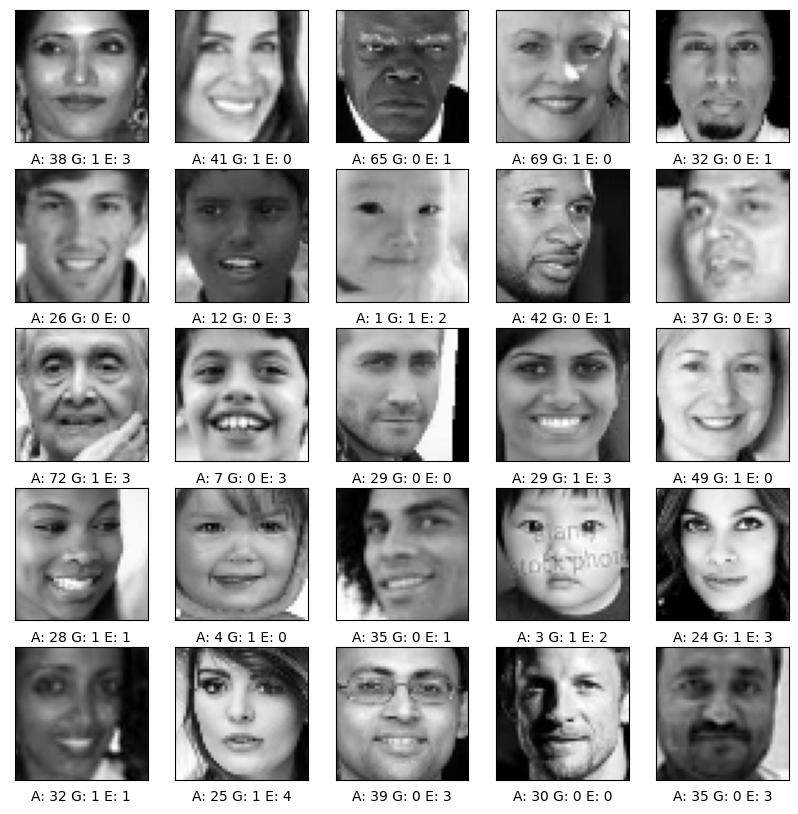

In [5]:
# size of the whole grid of images
plt.figure(figsize=(10, 10))

# display first 25 images in a 5x5 grid
for i in range(0, 25):
    plt.subplot(5, 5, (i % 25) + 1)
    plt.grid(False)
    #disable x and y axis description
    plt.xticks([])
    plt.yticks([])
    # each image is builds from 48 x 48 pixels
    plt.imshow(df['pixels'].iloc[i].reshape(48,48), cmap='gray')
    # could app mapping that if G = 0 then male, = 1 then female and similar with ethnicity
    # A = age, G = gender, E = ethnicity
    plt.xlabel("A: "+ str(df['age'].iloc[i])+ " G: " + str(df['gender'].iloc[i])+ " E: " + str(df['ethnicity'].iloc[i]))
plt.show()

We need to reshape pixels for convolution:

In [6]:
x = np.array(df['pixels'].tolist())
# x.shape[0] = 23705, those are number of entries in db file, last argument is 1 if greyscale, 3 if rgb images
x = x.reshape(x.shape[0], 48, 48, 1)

Prepare y values:

In [7]:
y_age = np.array(df['age'])
y_ethnicity = np.array(df['ethnicity'])
y_gender = np.array(df['gender'])

Split data into training and testing sets for each of the models (age, ethnicity and gender):

In [8]:
seed = 100
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size = 0.5, random_state = seed)
x_train_ethnicity, x_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(x, y_ethnicity, test_size = 0.5, random_state = seed)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size = 0.5, random_state = seed)

## Age prediction
Build the model: <br>layers faq - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [9]:
age_model = Sequential()

age_model.add(Conv2D(16, kernel_size = (3, 3), strides = 1, input_shape = x.shape[1:], padding = "same", activation = 'relu'))
age_model.add(MaxPooling2D(pool_size = (2,2)))

age_model.add(Conv2D(32, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu'))
age_model.add(MaxPooling2D(pool_size = (2,2)))

age_model.add(Conv2D(64, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu'))
age_model.add(MaxPooling2D(pool_size = (2,2)))

age_model.add(Conv2D(128, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu'))
age_model.add(MaxPooling2D(pool_size = (2,2)))

age_model.add(Flatten())

age_model.add(Dense(128, activation = 'relu'))
age_model.add(Dropout(0.3))
age_model.add(Dense(1, activation = 'relu')) # sigmoid

# check different optimizers and loss functions 'binary_crossentropy'
age_model.compile(optimizer = 'adam', loss = 'mae', metrics = ['accuracy'])
# age_model.summary()

Training:

In [10]:
age_history = age_model.fit(x_train_age, y_train_age, epochs = 10, validation_data = (x_test_age, y_test_age))

Epoch 1/10
371/371 [==============================] - 20s 47ms/step - loss: 16.2656 - accuracy: 0.0479 - val_loss: 14.6795 - val_accuracy: 0.0465
Epoch 2/10
371/371 [==============================] - 20s 53ms/step - loss: 14.7424 - accuracy: 0.0483 - val_loss: 13.6541 - val_accuracy: 0.0465
Epoch 3/10
371/371 [==============================] - 20s 55ms/step - loss: 13.1325 - accuracy: 0.0483 - val_loss: 11.4170 - val_accuracy: 0.0464
Epoch 4/10
371/371 [==============================] - 22s 58ms/step - loss: 11.0516 - accuracy: 0.0443 - val_loss: 9.6919 - val_accuracy: 0.0453
Epoch 5/10
371/371 [==============================] - 21s 57ms/step - loss: 10.0453 - accuracy: 0.0469 - val_loss: 9.3045 - val_accuracy: 0.0465
Epoch 6/10
371/371 [==============================] - 21s 56ms/step - loss: 9.2918 - accuracy: 0.0467 - val_loss: 8.6586 - val_accuracy: 0.0465
Epoch 7/10
371/371 [==============================] - 25s 67ms/step - loss: 8.9662 - accuracy: 0.0470 - val_loss: 8.3478 - val_a

Testing:

In [11]:
val_loss, val_acc = age_model.evaluate(x_test_age, y_test_age)

val_loss, val_acc

371/371 [==============================] - 4s 11ms/step - loss: 8.0675 - accuracy: 0.0465


(8.067481994628906, 0.04648612067103386)